# PEFT 微调实战

目前在中文领域，DeepSeek 和 Qwen 可以算是第一梯队的模型了。本次内容，我们就以 Qwen-1.8B 这个小模型为例，一步步演示下如何进行 PEFT 微调。

Qwen-1.8B 是 Qwen 系列的一个最小的版本，具有 18 亿参数。这个模型虽然在大模型家族中量级较小，但也能够处理中英双语的自然语言理解和生成任务。通过量化技术，Qwen-1.8B 可以在低至 4GB 显存的消费级显卡上运行（INT4 量化级别）。
Qwen-1.8B 在性能和开放性之间进行了良好的平衡，旨在为开发者提供一个强大且易用的对话交互基座，加速大模型在实际场景中的应用落地，很受中文世界用户的欢迎。这个模型的大小，也比较适合我们学习。
这是一个开源模型，可以直接从 HuggingFace 上下载。

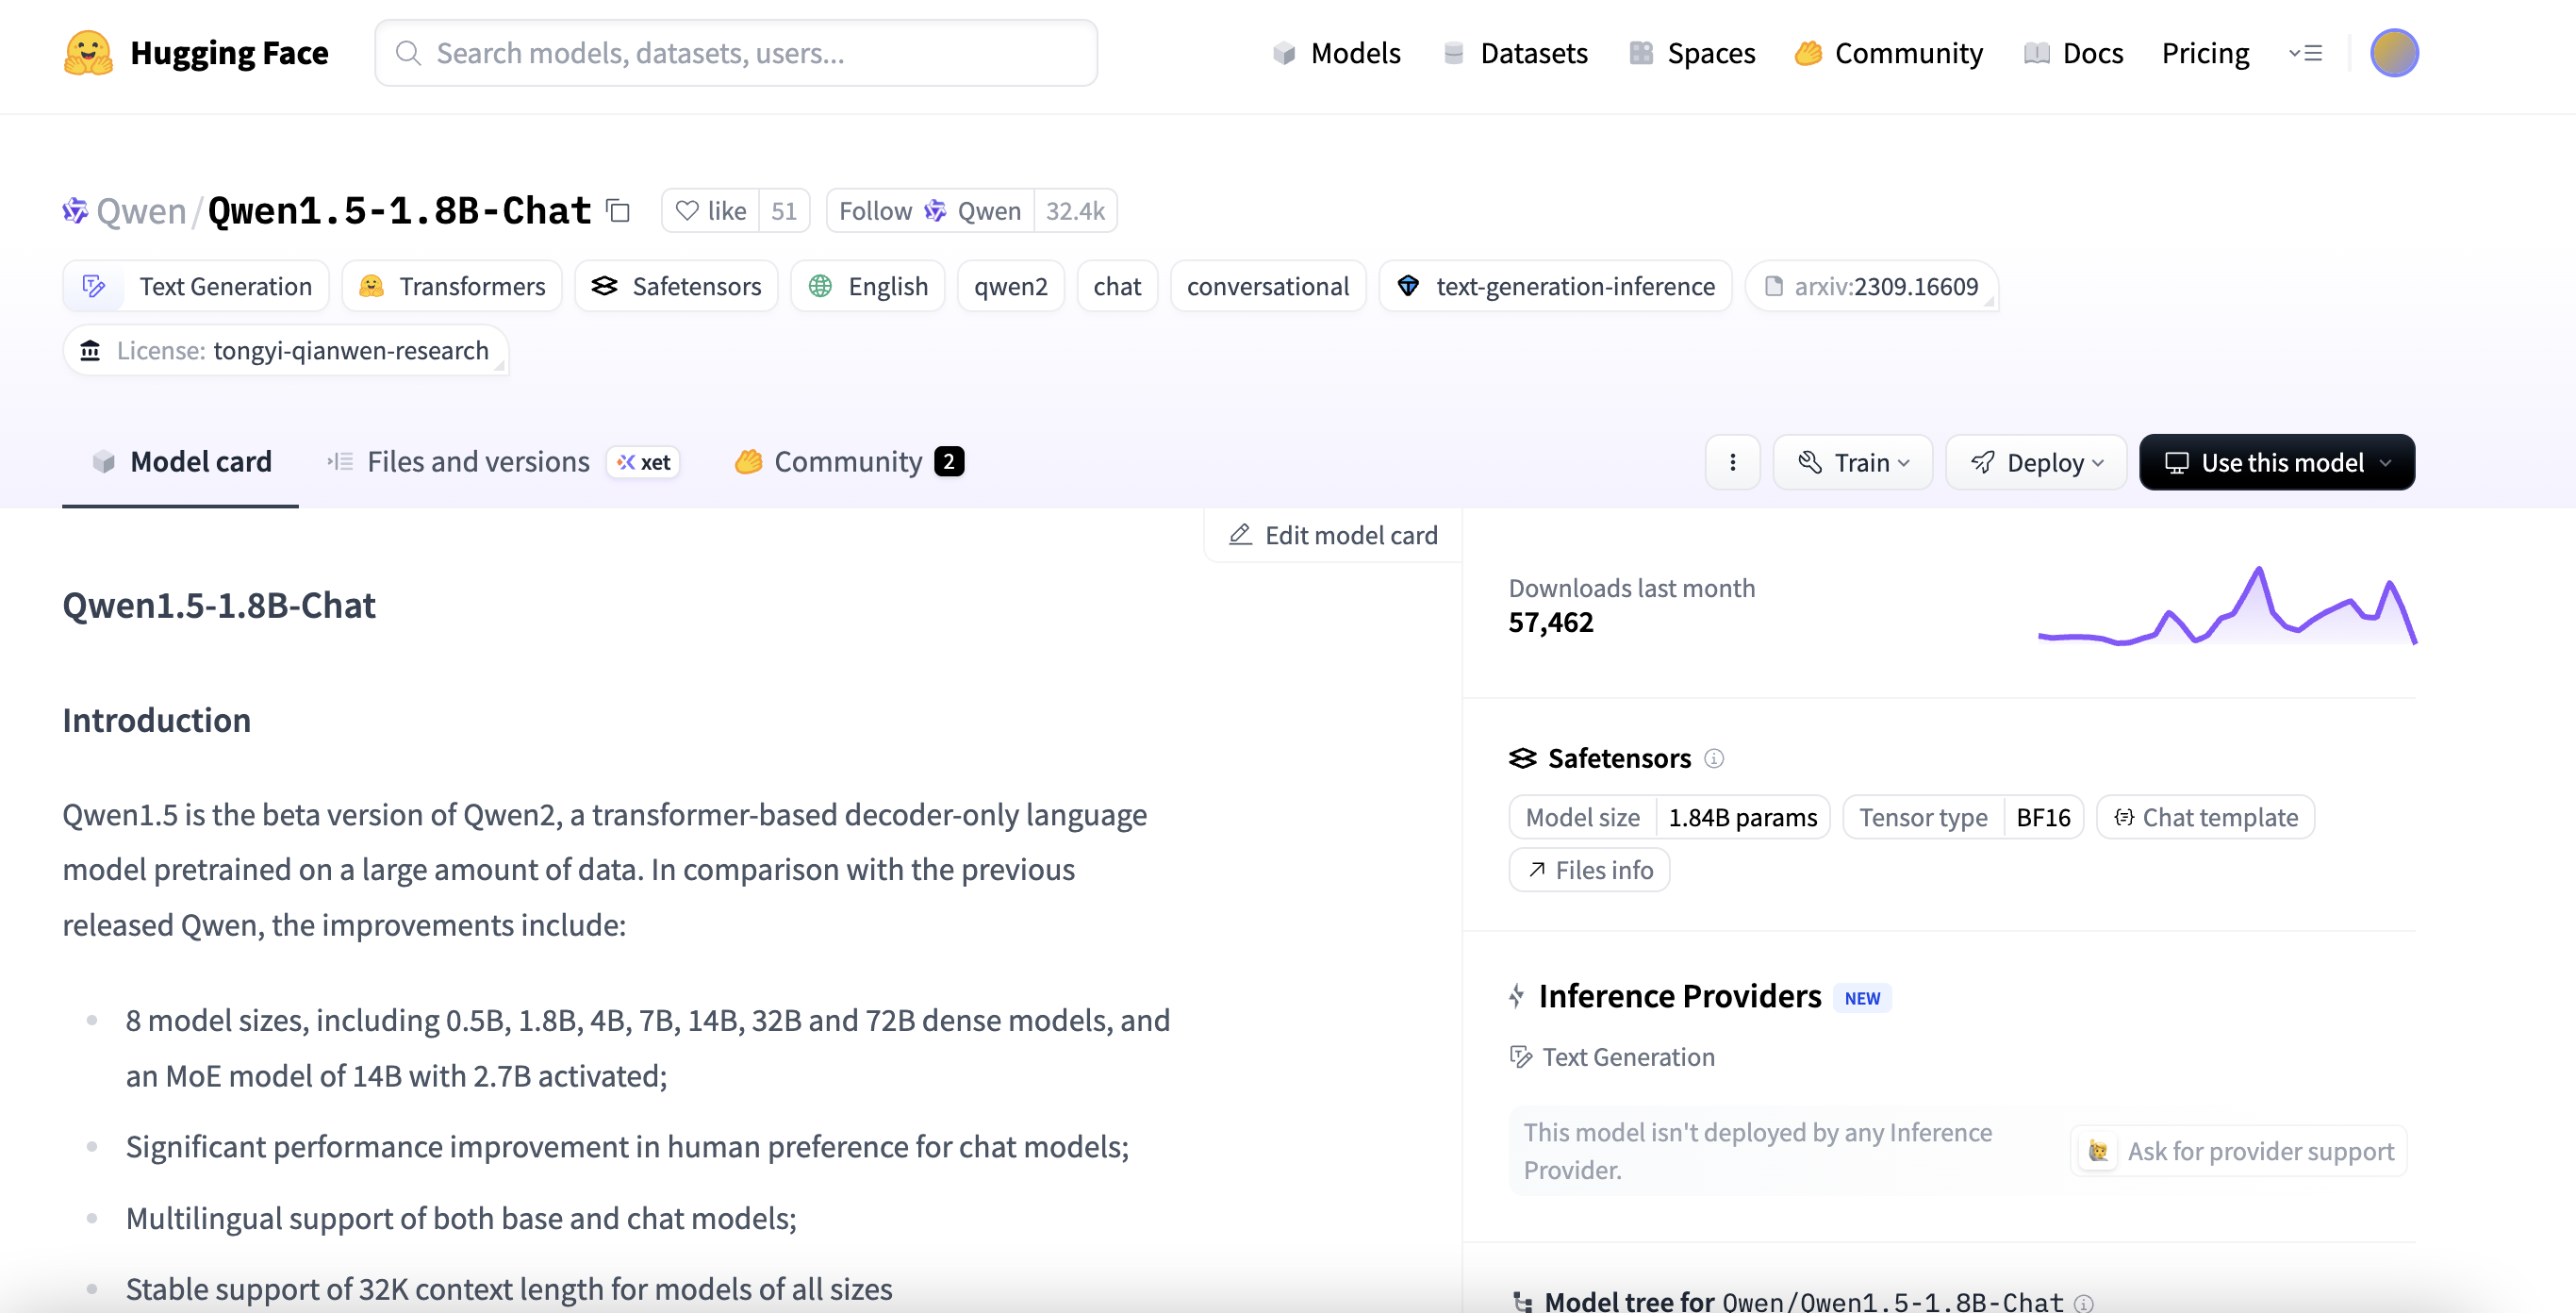

## 微调技术概览
我们之所以要对大模型继续微调，通常是要实现两个目标：第一个是让模型更切合自己的应用场景，更加适应特定的下游任务；第二个是模型能够变得更加轻便，节省资源。

针对这两个目标，业界主要采用以下几种微调方式：

- 全量微调（Full Fine-tuning）：这是最直接的微调方法。即在下游任务的训练数据上，对预训练模型的所有参数进行训练和更新。全量微调可以让模型充分适应新的任务，但需要更新的参数量巨大，对算力要求很高，而且有可能导致过拟合、遗忘预训练知识等问题。
- 部分微调（Partial Fine-tuning）：有选择地冻结一部分模型参数，只微调其中的一小部分参数（如最后几层）。这种方法可以在一定程度上减少所需的计算资源，但由于大部分参数没有更新，模型的适应能力也相对有限。
- 提示微调（Prompt-tuning）：通过学习输入文本的“软提示”（可训练的连续向量）来引导预训练模型执行目标任务，而无需改变原模型的参数。提示微调只需训练软提示参数，大大减少了训练开销。但生成的提示向量缺乏可解释性，泛化能力也有待进一步研究。
- Adapter 微调：在预训练模型的每一层（或部分层）注入轻量级的 Adapter 模块。微调时只训练这些新加入的 Adapter 参数，冻结原模型参数。Adapter 充当了任务适配器的角色，以较小的参数量和计算代价实现了模型适配。
- LoRA 微调：以低秩分解的思想对预训练模型进行微调。在每个注意力模块中引入低秩矩阵，在前向传播时与原矩阵相加得到适配后的权重。LoRA 只需训练新引入的低秩矩阵，参数开销很小，但能在下游任务上取得不错的效果。
- P-tuning v2：将连续的提示向量和 Adapter 的思想相结合，在每个 Transformer 层基础上引入可训练的提示嵌入。这些提示嵌入在前向传播时会注入到注意力矩阵和前馈层中。P-tuning v2 在保留预训练知识的同时，也能有效地进行任务适配。

不同的微调方法在参数效率、任务适应能力、实现难易度等方面各有优劣。针对具体任务，需要根据实际情况（如任务复杂度、训练数据规模、可用算力等）来选择合适的微调策略。

此外，基于模型部署的需求，模型蒸馏、量化、剪枝等模型压缩方法，也常常与微调方法配合使用，以进一步减小模型体积、加速推理速度，使大模型更容易在实际应用中落地，这个我们在后面的内容中会展开讨论。

## LoRA 技术简介

**在上面罗列的各种主流微调方法，除去全量微调之外，其实都可以称之为参数高效微调，也就是 PEFT，是针对大语言模型来说，最为实用的方法。** 毕竟大语言模型的主要问题是参数数量过大，做全量微调实在对资源的消耗太大，已经不是一般研究人员或者普通企业所能做的了。

PEFT 微调中的一条重要分支，就是基于**低秩分解的方法（LoRA methods），这一类方法通过低秩分解来近似表示要学习的增量权重矩阵**。
基于低秩分解的思想，可以用非常小的参数开销（新增参数量通常只有原模型的 0.1%~3%）来适配模型，在参数效率上非常有优势。

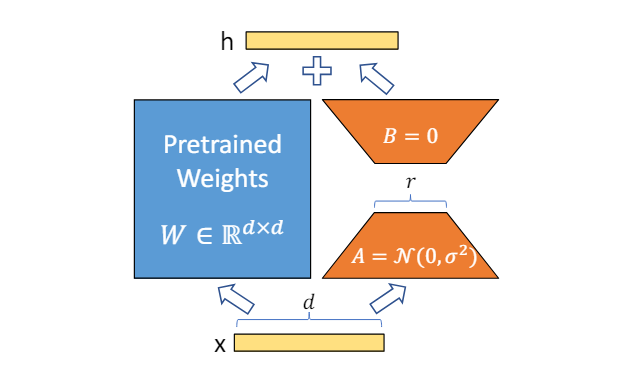

关于 LoRA 的更多技术细节，可以参考论文《LoRA: Low-Rank Adaptation of Large Language Models》

LoRA 这种方法有许多优点：

- LoRA 通过大幅减少可训练参数的数量，使微调更加高效。
- 原始预训练权重保持冻结，这意味着你可以拥有多个轻量级和便携式的 LoRA 模型，以便在其基础上构建各种下游任务。
- LoRA 与其他参数高效方法正交，并且可以与其中许多方法相结合。
- 使用 LoRA 微调的模型的性能，与完全微调的模型的性能相当。

**凭借参数少、计算快、效果好、易实现等优势，LoRA 成为了近年来最受欢迎的 PEFT 技术之一。包括 ChatGPT 在内的众多业界大模型，都采用了 LoRA 进行下游任务适配。**

所以，接下来我们就通过 LoRA 方法，来尝试微调 Qwen-1.8B 模型！

## 环境准备

首先说明下我本次微调所使用的环境：
- 操作系统版本：ubuntu 22.04
- GPU 型号：RTX 3090(24GB) 
- CUDA 版本：CUDA 12.6
- Python 版本：Python 3.10
- PyTorch 版本：PyTorch 2.7.0

需要特别注意的是：PyTorch 与 cuda 的版本一定要匹配，否则可能无法正常运行项目。具体版本的对应关系可以参考 PyTorch 官网：
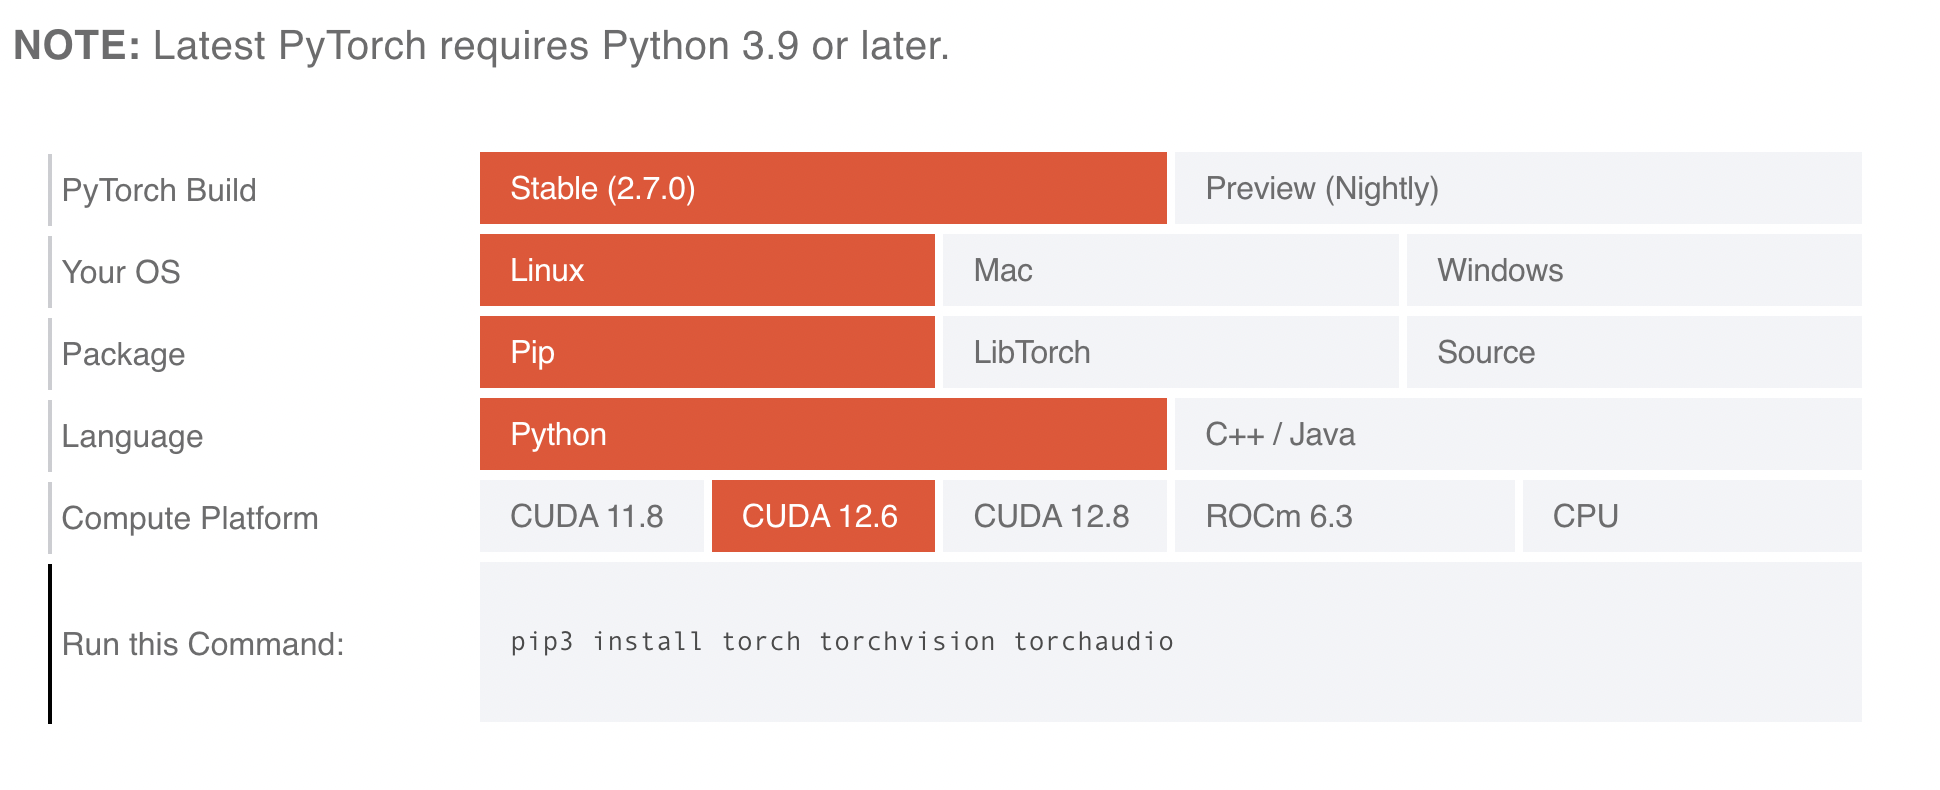

要从零开始手动实现上面的各种微调方法，当然不现实，好在我们有 Hugging Face 的 PEFT 框架。

**PEFT 是 Hugging Face 针对大模型微调而开发的一套框架，它旨在使大语言模型（LLMs）的微调过程更加高效和资源友好。这个框架提供了一些主要的技术，以减少微调所需的参数量和计算资源，同时仍保持模型在特定任务上的高性能。**

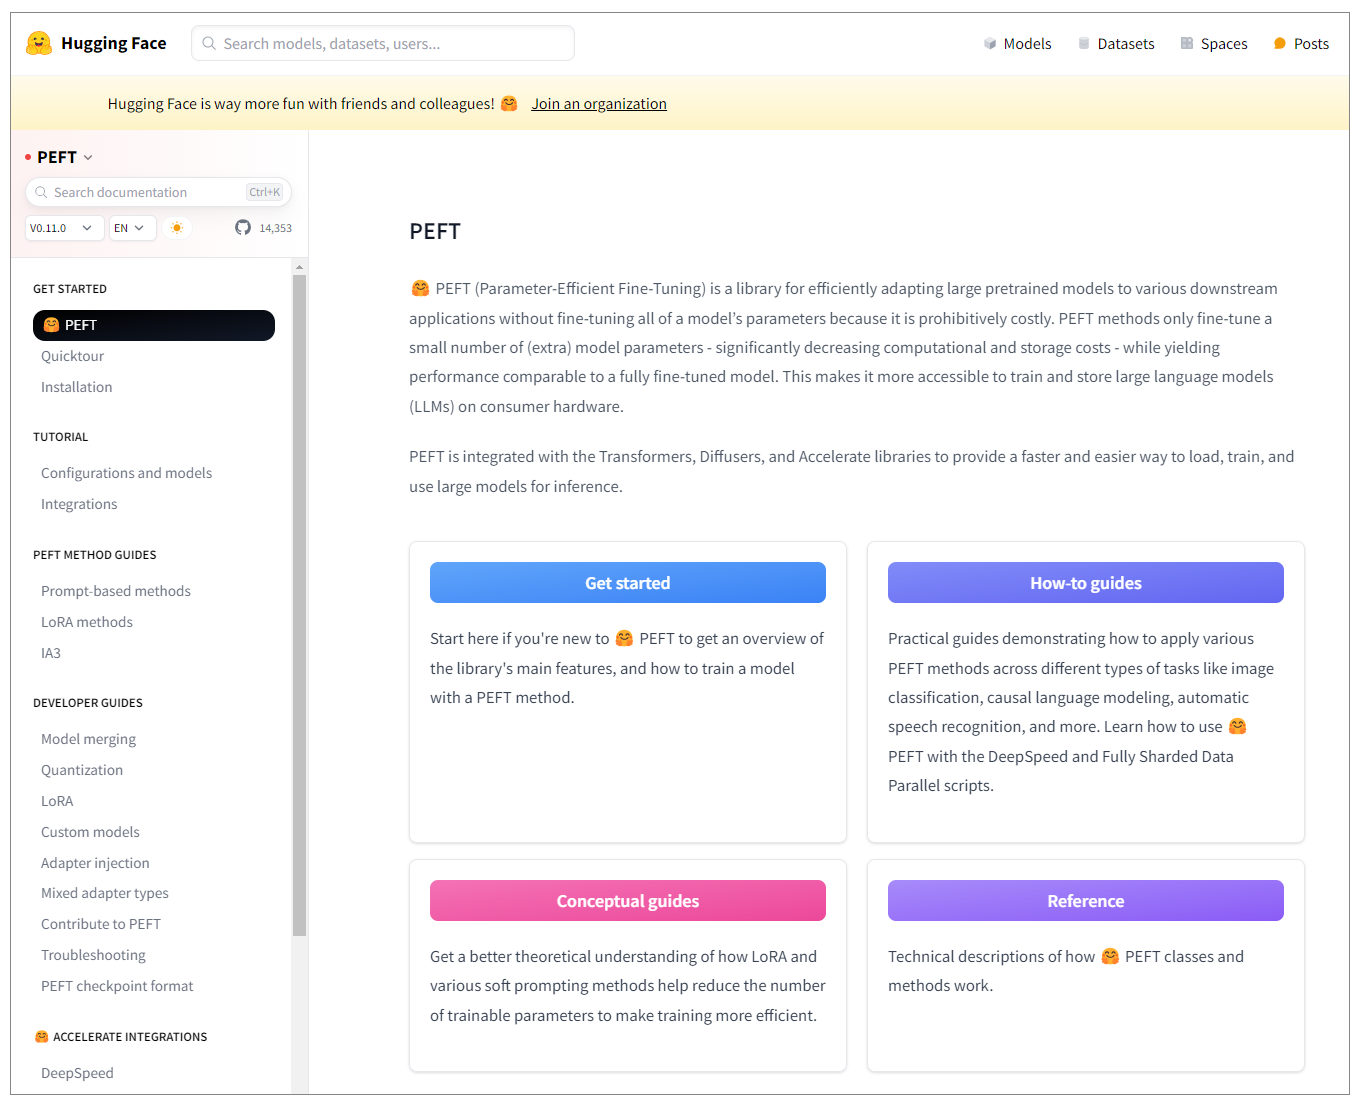

除了 peft 之外，我们微调还要依赖其它一些包，这里可以一起安装下：

In [2]:
!pip install peft transformers torch setuptools bitsandbytes datasets sentencepiece

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


因为 peft 和 transformers 库都需要访问 HuggingFace，为了加速访问，我们可以通过环境变量设置下镜像站：

In [1]:
import subprocess
import os

# 设置模型下载路径
os.environ["HF_HOME"] = "/root/autodl-tmp/volume/hf"
os.environ["HF_HUB_CACHE"] = "/root/autodl-tmp/volume/hub"

# 设置HuggingFace镜像站
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"


# 开启加速(仅针对AutoDL平台)
result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

## 准备数据

环境准备就绪，下面就开始我们的微调实战吧！

**通常来说，微调的第一步就是准备数据。** 我在使用 ChatGLM 提供的一个 Alpaca 风格的中文中药数据集，来作为我们本次微调的训练语料。
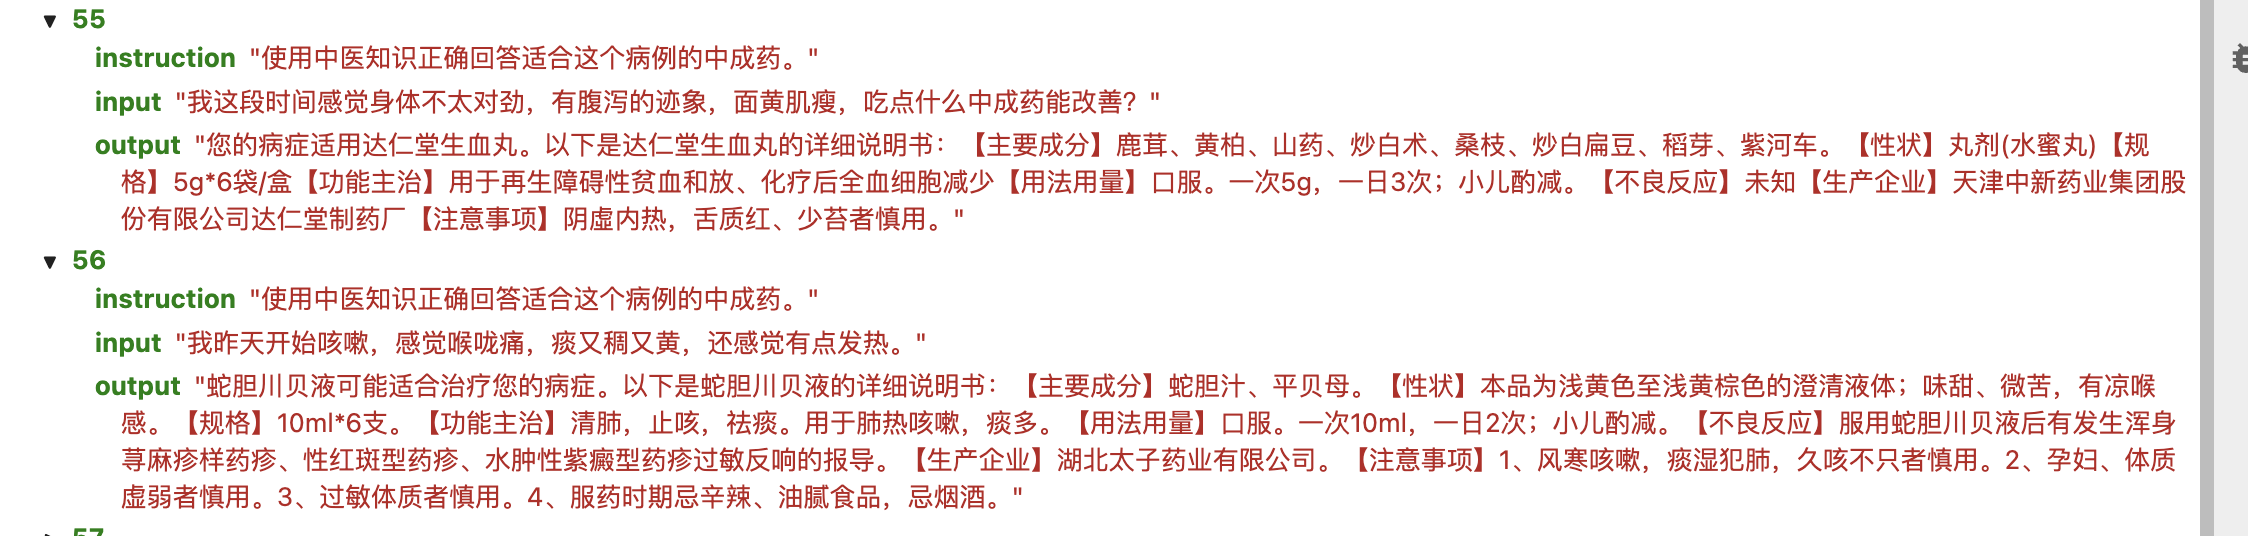

**Alpaca 是由 Meta 发布的一种主流的数据集格式，每条语料都包含 instruction、input 和 output 这三个字段。** 关于 Alpaca 风格的具体解释，这里就不赘述了，大家感兴趣的话可以自行搜索一下。 

在微调之前，我们先测试一下 Qwen1.5-1.8B-Chat 这个模型，看看微调前的效果。我向它提问几条中药相关的问题：

In [2]:
# 导入Hugging Face Transformers相关库
from transformers import AutoModelForCausalLM, AutoTokenizer

# 指定模型名称
MODEL = "Qwen/Qwen1.5-1.8B-Chat"

# 加载训练好的模型和分词器
# tokenizer和model要一一对应
tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(MODEL, trust_remote_code=True, device_map='auto')

# 模型设为评估状态
model.eval()

# 定义测试示例
examples = [
    {
        "instruction": "使用中医知识正确回答适合这个病例的中成药。",
        "input": "我这段时间感觉身体不太对劲，有腹泻的迹象，面黄肌瘦，吃点什么中成药能改善？"
    },
    {
        "instruction": "使用中医知识正确回答适合这个病例的中成药。",
        "input": "我昨天开始咳嗽，感觉喉咙痛，痰又稠又黄，还感觉有点发热。"
    }
]

# 测试模型生成结果
for example in examples:
    context = f"Instruction: {example['instruction']}\nInput: {example['input']}\nAnswer: "
    # 对输入文本进行编码
    inputs = tokenizer(context, return_tensors="pt") 
    # 模型生成回复
    outputs = model.generate(inputs.input_ids.to(model.device), max_length=512, num_return_sequences=1, no_repeat_ngram_size=2)
    # 对回复内容进行解码
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Input: {example['input']}")
    print(f"Output: {answer}\n")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Input: 我这段时间感觉身体不太对劲，有腹泻的迹象，面黄肌瘦，吃点什么中成药能改善？
Output: Instruction: 使用中医知识正确回答适合这个病例的中成药。
Input: 我这段时间感觉身体不太对劲，有腹泻的迹象，面黄肌瘦，吃点什么中成药能改善？
Answer: 以下是一些适用于你症状的中医中草药：

1. 黄连：具有清热解毒、燥湿止泻的功效。可用于治疗上腹部饱胀不适、恶心呕吐、泄泻等脾胃虚弱、湿热内阻的症状。

2. 柴胡：能够疏肝解郁，帮助消化和排泄。对于腹痛、食欲不振、腹泻等症状有一定的缓解作用。

3. 薏苡仁：有助于清利湿浊，消食化滞。常用于脾胃气虚、饮食不节引起的腹泻、腹胀等症状。

4. 白术：健脾益胃，增强免疫力。可以有效缓解脾胃湿困导致的腹满、口淡乏味、大便溏稀等症状，同时还能提高人体的抗病能力。

5. 阿胶：滋阴补血，润肠通便。长期使用可改善脾胃功能，促进食物吸收和排出，对于久腹泻或者伴有血虚的症状十分适宜。

6. 当归：活血调经，温阳补肾。在调理脾胃方面，当归可以起到很好的协同作用，如对于因湿邪所致的腹泻，可用当归属以散寒行湿、温养脾脏；对于肝肾不足、腰膝酸软、头晕耳鸣等症状也有一定的辅助治疗作用。但需注意，本品性平，孕妇慎用或应在医生指导下使用。

7. 川贝母：化痰止咳，清肺止喘。如果腹泻伴有咳嗽或喉咙不适，川贝可助其化饮止痰，缓解咽部不适。

以上药物应根据个体情况和具体病情进行选择和调配，若出现严重的副作用或持续腹泻等情况应及时就医，并遵医嘱服用。同时，在日常生活中保持良好的生活习惯，避免过度劳累，合理饮食，适量运动，以达到更好的保健效果。

Input: 我昨天开始咳嗽，感觉喉咙痛，痰又稠又黄，还感觉有点发热。
Output: Instruction: 使用中医知识正确回答适合这个病例的中成药。
Input: 我昨天开始咳嗽，感觉喉咙痛，痰又稠又黄，还感觉有点发热。
Answer: 你的症状可能与感冒或者肺炎有关，中医认为这可能属于风热犯肺、燥热内结的范畴。以下是一些适合治疗这类疾病的中草药：

1. 清肺化痰止咳颗粒：具有清热化湿、宣肺止嗽的功效，适用于风寒感冒、风邪袭肺导致的咳嗽、痰多等症状。该药物主要成分有连翘、板蓝根、桑白皮等，其中连翿能清解风毒，板兰根可凉血消肿，桑白色皮能润肺生津。

2. 麻杏石甘汤

执行这段代码，会首先从 HuggingFace 上，将模型下载到本地，之后采用本地的模型进行推理。
**注意：因为我们还没有进行微调，所以此时模型生成的结果还是基于之前预训练的数据，并不一定是真实准确的。**

## 进行微调

我们确认了模型已经被拉取到本地，并且可以正常运行，接下来，就可以正式开始微调了。

首先，我们需要自定义数据集，**继承 Pytorch 的 Dataset 类**，这样就将刚才下载下来的数据集转化成模型可以理解的格式：

In [3]:
# 导入Dataset
from torch.utils.data import Dataset
import json

# 自定义中药数据集
class MedicineDataset(Dataset):
    def __init__(self, data_path, tokenizer, device):
        self.data = json.load(open(data_path))
        self.tokenizer = tokenizer
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        formatted_example = self.format_example(example)
        inputs = self.tokenizer(
            formatted_example["context"],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        labels = self.tokenizer(
            formatted_example["target"],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        inputs["labels"] = labels["input_ids"]
        # 确保所有张量在同一个设备上
        return {key: val.squeeze().to(self.device) for key, val in inputs.items()}

    def format_example(self, example: dict) -> dict:
        context = f"Instruction: {example['instruction']}\n"
        if example.get("input"):
            context += f"Input: {example['input']}\n"
        context += "Answer: "
        target = example["output"]
        return {"context": context, "target": target}




接下来，对需要微调的模型进行一些设置：

In [4]:
# 导入微调模型所需的库
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 指定模型
MODEL = "Qwen/Qwen1.5-1.8B-Chat"

# 判断设备类型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载分词器和模型
tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(MODEL, trust_remote_code=True)

# 把模型移动到设备上
model = model.to(device) 

# 节省内存的一些配置
model.supports_gradient_checkpointing = True  # 支持梯度检查点功能，减少显存使用
model.gradient_checkpointing_enable()  # 启用梯度检查点功能，减少训练时的显存占用
model.enable_input_require_grads()  # 允许模型输入的张量需要梯度，支持更灵活的梯度计算
model.is_parallelizable = True  # 指定模型可以并行化处理
model.model_parallel = True  # 启用模型并行化，在多设备(如多GPU)上分布计算

**然后是比较关键的一步：LoRA 配置。**
这些配置项帮助用户在训练语言模型时应用 LoRA 技术，通过低秩分解，减少模型参数和内存占用，并使用 dropout 技术防止过拟合，
同时仅在特定模块上应用 LoRA，从而在计算效率和模型性能之间取得平衡。

In [5]:
# 导入peft库
from peft import get_peft_model, LoraConfig, TaskType

# 配置LoRA相关参数
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, # 任务类型: 因果语言模型(Causal LM)
    inference_mode=False, # 设置推理模式为False,表示当前配置用于训练模式,而非推理模式
    r=8, # 设置低秩分解的秩: Rank=8。r越小,表示模型的参数量和内存占用越少,压缩程度越高
    lora_alpha=32, # 设置缩放因子：lora_alpha=32
    lora_dropout=0.1, # 设置dropout概率：lora_dropout=0.1,表示有10%的神经元会被丢弃,此操作有助于防止模型过拟合,提升模型的泛化能力
    target_modules=["q_proj", "v_proj"]  # 查询投影和值投影模块
)

# 在模型上应用LoRA配置
model = get_peft_model(model, peft_config) 

/root/miniconda3/lib/python3.10/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


相关的前置工作已经都 ready 了，下一步就可以直接进行微调了：

In [6]:
# 创建训练数据集
train_dataset = MedicineDataset("./data/dataset/cpmi_dataset.json", tokenizer, device)

# 导入训练相关的库
from transformers import TrainingArguments, Trainer

# 定义训练参数
training_args = TrainingArguments(
    output_dir="./results",  # 训练结果保存的目录
    num_train_epochs=15,  # 训练的总轮数,每一轮都需要跑完全部训练集
    per_device_train_batch_size=4,  # 每个设备上的训练批次大小
    gradient_accumulation_steps=8,  # 梯度累积步数，在进行反向传播前累积多少步
    # evaluation_strategy="no",  # 评估策略，这里设置为不评估
    save_strategy="epoch",  # 保存策略，每个 epoch 保存一次模型
    learning_rate=5e-5,  # 学习率
    fp16=True,  # 启用 16 位浮点数训练，提高训练速度并减少显存使用
    logging_dir="./logs",  # 日志保存目录
    dataloader_pin_memory=False,  # 禁用pin_memory以节省内存
)

# 自定义 Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # 从输入中取出标签
        outputs = model(**inputs)  # 获取模型输出
        logits = outputs.logits  # 获取模型输出的logits
        shift_logits = logits[..., :-1, :].contiguous()  # 对logits进行偏移，准备计算交叉熵损失
        shift_labels = labels[..., 1:].contiguous()  # 对标签进行偏移，准备计算交叉熵损失
        loss_fct = torch.nn.CrossEntropyLoss()  # 定义交叉熵损失函数
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))  # 计算损失
        return (loss, outputs) if return_outputs else loss  # 根据参数返回损失和输出

# 定义 Trainer
trainer = CustomTrainer(
    model=model,  # 训练的模型
    args=training_args,  # 训练参数
    train_dataset=train_dataset,  # 训练数据集
)

# 开始微调
print("开始微调")
trainer.train()
print("微调完成")

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


开始微调


Step,Training Loss
500,31.409600
1000,24.720800
1500,24.186200


微调完成


我们指定了训练的轮数为50轮，在实际的生产环境中，训练的轮数通常会更多，并且要结合不断的调参，才能达到较好的训练效果。
**这里我们可以看到，随着模型训练的轮数越来越多，损失函数也在逐渐收敛。**
跑完训练之后，我们可以将微调好的模型保存到本地。

In [7]:
import os

# 微调后模型的保存路径
FINE_TUNING_DIR = "./fine-tuning-qwen1.5-1.8b-chat"

# 保存训练后的模型和配置文件
model.save_pretrained(FINE_TUNING_DIR)
tokenizer.save_pretrained(FINE_TUNING_DIR)

# 将配置文件下载到模型目录中
config = model.config.to_dict()
config_path = os.path.join(FINE_TUNING_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

print(f"微调后的模型已经成功保存到: {FINE_TUNING_DIR}")

微调后的模型已经成功保存到: ./fine-tuning-qwen1.5-1.8b-chat


**这样一来，整个微调过程就结束了，是不是没有那么复杂？**

## 模型评估
**微调完成之后，最后一步就是模型评估**，也就是在微调后的模型上再次测试同样的问题，看看模型生成的回复是否与参考数据集中的内容一致。

In [10]:
# 导入所需要的库
from transformers import AutoModelForCausalLM, AutoTokenizer


# 加载训练好的模型和分词器
tokenizer = AutoTokenizer.from_pretrained(FINE_TUNING_DIR, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(FINE_TUNING_DIR, trust_remote_code=True, device_map='auto')

# 模型设为评估状态
model.eval()

# 定义测试示例
questions = [
    {
        "instruction": "使用中医知识正确回答适合这个病例的中成药。",
        "input": "我这段时间感觉身体不太对劲，有腹泻的迹象，面黄肌瘦，吃点什么中成药能改善？"
    },
    {
        "instruction": "使用中医知识正确回答适合这个病例的中成药。",
        "input": "我昨天开始咳嗽，感觉喉咙痛，痰又稠又黄，还感觉有点发热。"
    }
]

# 生成回复
for question in questions:
    context = f"Instruction: {question['instruction']}\nInput: {question['input']}\nAnswer: "
    # 对输入文本进行编码
    inputs = tokenizer(context, return_tensors="pt") 
    # 模型生成回复
    outputs = model.generate(inputs.input_ids.to(model.device), max_length=128, num_return_sequences=1, no_repeat_ngram_size=2)
    # 对回复内容进行解码
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Input: {question['input']}")
    print(f"Output: {answer}\n")

Input: 我这段时间感觉身体不太对劲，有腹泻的迹象，面黄肌瘦，吃点什么中成药能改善？
Output: Instruction: 使用中医知识正确回答适合这个病例的中成药。
Input: 我这段时间感觉身体不太对劲，有腹泻的迹象，面黄肌瘦，吃点什么中成药能改善？
Answer: 、【子气为）、茯当、芪芪甘草仁、炒味、、本为粉制、黄芍。、为。(性状)白。蜜、）术品、归补、。至】、芍（或功能。；。醋皮、粉为、衣，本性。红芍芩、皮参。山赤当泽、心

Input: 我昨天开始咳嗽，感觉喉咙痛，痰又稠又黄，还感觉有点发热。
Output: Instruction: 使用中医知识正确回答适合这个病例的中成药。
Input: 我昨天开始咳嗽，感觉喉咙痛，痰又稠又黄，还感觉有点发热。
Answer: 、性、荆子、、；香子草】粉甘。、苦气蜜、芩术（、白)、为）、品状味。的、，至毒大、）、味、粉状、草、仁、皮、去。本、的状毒。内容为、芍、【，心草炙、（，、)芦衣、黄、荷、心、大为



**令人欣喜的是，微调后的 Qwen 的生成质量得到了大幅提升，虽然不是百分之百准确，但是很明显我们数据集中的知识，已经被纳入了 Qwen 模型的知识体系中，可以认为本次微调任务是成功的！**

## 小结
本节课我们学习了参数高效微调的基本原理，介绍了 PEFT 框架，更重要的是，我们基于 LoRA 对 Qwen 模型进行了微调，使其在中医领域问答任务上取得了基于我们知识库的结果，而不是它原有的认知。利用 LoRA 等参数高效微调技术，我们可以用较小的计算开销，快速适配预训练模型到特定任务，让模型获得新的领域知识，同时又能保留原有的语言理解和生成能力，这为大语言模型在垂直领域的应用提供了新的思路，也降低了大模型应用落地的门槛。在本课中，我们也涉及到了一些如何有效利用当前 GPU 内存的方法，包括梯度检查点、多卡并行等等。其实，在微调的同时，如何为大模型做进一步的瘦身，非常值得讨论。我们将在下一节课继续这一部分的学习之旅。